In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

import random
from datetime import datetime

In [3]:
solvent_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'solvent')
solvent_data.set_index('solvent_name', inplace = True)
solvent_columns = list(solvent_data.columns)

In [4]:
nucleophile_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'nucleophiles')
nucleophile_data.set_index('nucleophile_name', inplace = True)
nucleophile_columns = list(nucleophile_data.columns)

In [5]:
raw_catalyst_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

#Taking care of catalyst R/S
r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')
    #print(r_catalyst_data.iloc[i, 1])
#r_catalyst_data.drop(17, inplace = True)

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')
    #print(s_catalyst_data.iloc[i, 1])

catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)
catalyst_data.set_index('catalyst_name', inplace = True)

catalyst_columns = list(catalyst_data.columns)



In [6]:

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/material_project/data')
catalyst_data.to_excel('catalyst_data_is.xlsx')
r_catalyst_data.to_excel('r_catalyst_data_is.xlsx')
s_catalyst_data.to_excel('s_catalyst_data_is.xlsx')

In [7]:
iminium_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'iminiums')
iminium_data.rename(columns = {'imine': 'iminium_name', 'electronic energy difference (kcal/mol) ': 'electronic energy difference (kcal/mol)'}, inplace = True)
#removed space at the end of electronic energy
iminium_data.set_index('iminium_name', inplace = True)
iminium_data.drop(labels = ['Unnamed: 1'], axis = 1, inplace = True)
for i in range(1, 181):
    z_iminium_name = '(Z)-Iminium ' + str(i)
    e_iminium_name = '(E)-Iminium ' + str(i)
    iminium_data.loc[z_iminium_name, 'electronic energy difference (kcal/mol)'] = iminium_data.loc[e_iminium_name, 'electronic energy difference (kcal/mol)']
iminium_columns = list(iminium_data.columns)

In [8]:
class Reaction():

    def __init__(self, name, entry, catalyst, nucleophile, substrate, solvent, iminium_type, iminium, majorenantiomer, minorenantiomer, ee, G):
        self.name = name
        self.entry = entry
        self.catalyst = catalyst
        self.nucleophile = nucleophile
        self.substrate = substrate
        self.solvent = solvent
        self.iminium_type = iminium_type
        self.iminium = iminium
        self.majorenantiomer = majorenantiomer
        self.minorenantiomer = minorenantiomer
        self.ee = ee
        self.G = G

        self.solvent_properties = dict()
        for column in solvent_columns:
            self.solvent_properties[column] = solvent_data.loc[solvent, column]

        self.catalyst_properties = dict()
        for column in catalyst_columns:
            self.catalyst_properties[column] = catalyst_data.loc[catalyst, column]

        self.nucleophile_properties = dict()
        for column in nucleophile_columns:
            self.nucleophile_properties[column] = nucleophile_data.loc[nucleophile, column]

        self.e_iminium = '(E)-' + str(iminium)
        self.z_iminium = '(Z)-' + str(iminium)

        self.e_iminium_properties = dict()
        self.z_iminium_properties = dict()
        for column in iminium_columns:
            self.e_iminium_properties[column] = iminium_data.loc[self.e_iminium, column]
            self.z_iminium_properties[column] = iminium_data.loc[self.z_iminium, column]



    def __repr__(self):
        return "Reaction - {}".format(self.name)
        #iminium stuff

In [9]:
reactions = dict()

def process_data(reaction_number, reaction, iminium_type, sheetname = None):
    reaction_file = '/content/drive/My Drive/Colab Notebooks/material_project/data/reaction information/' + str(reaction_number) + ' ' + reaction + '.xlsx'
    if sheetname == None:
        data = pd.read_excel(reaction_file)
    else:
        data = pd.read_excel(reaction_file, sheet_name = sheetname)

    data.set_index('entry', inplace = True)

    entries = len(data)
    for entry in range(1, entries + 1):
        if sheetname == None:
            reaction_name = reaction + ' ' + str(entry)
        else:
            reaction_name = reaction + ' ' + sheetname + ' ' + str(entry)


        reactions[reaction_name] = Reaction(reaction_name,
                                            entry,
                                            data.loc[entry, 'Catalyst'],
                                            data.loc[entry, 'Nucleophile'],
                                            data.loc[entry, 'Substrate'],
                                            data.loc[entry, 'Solvent'],
                                            iminium_type,
                                            data.loc[entry, 'Iminium'],
                                            data.loc[entry, 'Major Enantiomer'],
                                            data.loc[entry, 'Minor Enantiomer'],
                                            data.loc[entry, 'ee'],
                                            data.loc[entry, 'ΔΔG‡'])



In [10]:
process_data(1, 'Addition of Alcohols', 'E', 'Scope')
process_data(2, 'Addition of thiols', 'E', 'Catalyst & solvent screening da')
process_data(2, 'Addition of thiols', 'E', 'Effect of catalyst loading')
process_data(2, 'Addition of thiols', 'E', 'Imine scope')
process_data(2, 'Addition of thiols', 'E', 'Thiol scope')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Catalyst screening data')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Scope')
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Optimization of catalyst and re")
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Imine scope")
process_data(5, 'Addition of diazoacetamides', 'E', 'Catalyst screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Solvent screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Substrate(s) scope')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Catalyst screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Solvent screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Imine scope')
process_data(7, 'Peroxidation of imines', 'E', 'Catalyst screening data')
process_data(7, 'Peroxidation of imines', 'E', 'Solvent screening data')
# process_data(7, 'Peroxidation of imines', 'E', 'Substrate(s) scope')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Catalyst screening and reaction')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Scope')
process_data(9, 'Transfer Hydrogenation of Enamides', 'E', 'Scope')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Catalyst screening data')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Imine scope')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Catalyst screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Solvent screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Imine scope')
# process_data(12, 'Reductive amination of N-aryl imines (Macmillan)', 'Z', 'Reaction optimization')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Imine scope')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Catalyst screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Benzothiazoline screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Imine scope')
# process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Catalyst screening data')
# process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Imine scope')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 1 benzothiazoline')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 2 dihydropyridine')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Catalyst screening data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Solvent data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Imine scope')
#process_data(18, 'Addition of enecarbamates to benzoyl imines')
#process_data(19, 'Hydrogenation of fluorinated alkynyl ketimines')
#process_data(20, 'Addition of thiols to imines (Denmark)')

In [11]:
print(len(reactions))

342


In [12]:
catalyst = pd.DataFrame(columns = ['Reaction'] + catalyst_columns)
catalyst.set_index('Reaction', inplace = True)
i=0
for reaction in reactions:
    i=i+1
    # print(i)
    # print(reaction)
    for column in catalyst_columns:
        catalyst.loc[reaction, column] = reactions[reaction].catalyst_properties[column]

#first column is numerical

In [13]:
nucleophile = pd.DataFrame(columns = ['Reaction'] + nucleophile_columns)
nucleophile.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in nucleophile_columns:
        nucleophile.loc[reaction, column] = reactions[reaction].nucleophile_properties[column]

#first column is numerical

In [14]:
nucleophile = nucleophile.rename(columns={'Polarizability': 'Polarizability (nucleophile)'})
nucleophile = nucleophile.rename(columns={'H': 'H (nucleophile)'})
nucleophile = nucleophile.rename(columns={'HOMO': 'HOMO (nucleophile)'})
nucleophile = nucleophile.rename(columns={'LUMO': 'LUMO (nucleophile)'})
nucleophile.head()
nucleophile_columns = list(nucleophile.columns)


In [15]:
solvent = pd.DataFrame(columns = ['Reaction'] + solvent_columns)
solvent.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in solvent_columns:
        solvent.loc[reaction, column] = reactions[reaction].solvent_properties[column]

#first column is numerical

In [16]:
solvent = solvent.rename(columns={'Polarizability': 'Polarizability (solvent)'})
solvent= solvent.rename(columns={'HOMO': 'HOMO (solvent)'})
solvent = solvent.rename(columns={'LUMO': 'LUMO (solvent)'})
solvent.head()
solvent_columns = list(solvent.columns)

In [17]:
iminium = pd.DataFrame(columns = ['Reaction', "iminium_type"] + iminium_columns)
iminium.set_index('Reaction', inplace = True)

for reaction in reactions:
    if reactions[reaction].iminium_type == 'E':
        iminium.loc[reaction, "iminium_type"] = 'E'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].e_iminium_properties[column]
    elif reactions[reaction].iminium_type == 'Z':
        iminium.loc[reaction, "iminium_type"] = 'Z'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].z_iminium_properties[column]



In [18]:
iminium = iminium.rename(columns={'LUMO': 'LUMO (iminium)'})
iminium = iminium.rename(columns={'H': 'H (iminium)'})
iminium = iminium.rename(columns={'HOMO': 'HOMO (iminium)'})
iminium = iminium.rename(columns={'Polarizability': 'Polarizability (iminium)'})
iminium.head()
iminium_columns = list(iminium.columns)

In [19]:
ee = pd.DataFrame(columns = ['Reaction', 'ee'])
ee.set_index('Reaction', inplace = True)

for reaction in reactions:
    ee.loc[reaction, 'ee'] = reactions[reaction].ee

In [20]:
Y = pd.DataFrame(columns = ['Reaction', 'ΔΔG‡'])
Y.set_index('Reaction', inplace = True)

for reaction in reactions:
    Y.loc[reaction, 'ΔΔG‡'] = reactions[reaction].G


In [21]:
Y.to_excel('Y_reaction_is.xlsx')

In [22]:
Y.shape

(342, 1)

In [23]:
print(catalyst.shape, nucleophile.shape, solvent.shape, iminium.shape, ee.shape)

(342, 85) (342, 15) (342, 160) (342, 22) (342, 1)


In [24]:
X_iminium = pd.concat([catalyst.drop(['Ar group'], axis = 1),
               nucleophile.drop(['nucleophile'], axis = 1),
               solvent.drop(['solvent'], axis = 1),
               iminium.drop(['iminium_type'], axis = 1)], axis = 1)
X_iminium.shape

(342, 278)

In [25]:
X_imi_nuc = pd.concat([
               nucleophile.drop(['nucleophile'], axis = 1),
               iminium.drop(['iminium_type'], axis = 1)], axis = 1)
X_imi_nuc.shape

(342, 35)

In [26]:
#no iminium features
X_no_iminium = pd.concat([catalyst.drop(['Ar group'], axis = 1),
               nucleophile.drop(['nucleophile'], axis = 1),
               solvent.drop(['solvent'], axis = 1)], axis = 1)
X_no_iminium.shape

(342, 257)

In [27]:
X_no_nucleophile = pd.concat([catalyst.drop(['Ar group'], axis = 1),
                   solvent.drop(['solvent'], axis = 1)], axis = 1)
X_no_nucleophile.shape

(342, 243)

In [28]:
for reaction in reactions:
    if iminium.loc[reaction, 'iminium_type'] == 'Z':
        Y.loc[reaction, 'ΔΔG‡'] = Y.loc[reaction, 'ΔΔG‡'] * (-1)

###############################################################################################################################

Reactions 18 - 20

###############################################################################################################################

In [29]:
#out of sample
X_oos = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/X_oos.xlsx',index_col = 'Reaction')

X_oos_iminium = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/X_oos_iminium.xlsx',index_col = 'Reaction')
X_oos_only_imi_nuc = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/X_oos_only_imi_nuc.xlsx',index_col = 'Reaction')
Y_oos = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Y_oos.xlsx',index_col = 'Reaction')
X_only_imi_nuc = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/X_only_imi_nuc.xlsx',index_col = 'Reaction')



In [30]:
new_column_names =list(X_iminium.columns)
name_map = {old_name: new_name for old_name, new_name in zip(X_oos_iminium.columns, new_column_names)}
X_oos_iminium=X_oos_iminium.rename(columns=name_map)

In [31]:
new_column_names =list(X_only_imi_nuc.columns)
name_map = {old_name: new_name for old_name, new_name in zip(X_oos_only_imi_nuc.columns, new_column_names)}
X_oos_only_imi_nuc=X_oos_only_imi_nuc.rename(columns=name_map)

###############################################################################################################################

End of Data Processing

###############################################################################################################################

In [32]:
X = X_iminium

In [33]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.1, random_state = 1)

In [34]:
Y_test1_00=Y_test1.iloc[0:12]
Y_test1_11=Y_test1.iloc[12:24]
Y_test1_22=Y_test1.iloc[24:35]

In [35]:
os.chdir('/content/drive/My Drive/Colab Notebooks/material_project/code/original/chem_brandeis/IEEE_BIBM')
X_train2 = pd.read_excel('X_train2.xlsx', index_col=0)
X_train2 = pd.read_excel('X_train2_rename.xlsx', index_col=0)

In [36]:
Y_test1_00.shape

(12, 1)

In [37]:
X_test1_00=X_test1.iloc[0:12, :]
X_test1_11=X_test1.iloc[12:24, :]
X_test1_22=X_test1.iloc[24:35, :]

In [38]:
print(X_test1_00.shape)
print(X_test1_11.shape)
print(X_test1_22.shape)

(12, 278)
(12, 278)
(11, 278)


In [39]:
X_train1.shape

(307, 278)

In [40]:
X_total = pd.concat([X_iminium, X_oos_iminium])
X_total_scaled = X_total
X_total_scaled = pd.DataFrame(X_total_scaled, columns = list(X_total.columns), index = list(X_total.index))

X_scaled = X_total_scaled.iloc[:342, :]
X_oos_scaled = X_total_scaled.iloc[342:, :]

In [41]:
catalyst_columns.remove('Ar group')
nucleophile_columns.remove('nucleophile')
solvent_columns.remove('solvent')
catalyst_columns
nucleophile_columns
solvent_columns
iminium_columns

['iminium_type',
 'nNH',
 'i NH',
 'N',
 'H (iminium)',
 'C',
 'SubL',
 'SubS',
 'PG',
 'PGL',
 'PGB1',
 'PGB5',
 'SL',
 'SB1',
 'SB5',
 'LL',
 'LB1',
 'LB5',
 'HOMO (iminium)',
 'LUMO (iminium)',
 'Polarizability (iminium)',
 'electronic energy difference (kcal/mol)']

In [42]:
X_total_nuc = X_total.loc[:, catalyst_columns + nucleophile_columns + solvent_columns]
# X_is_nuc = X.loc[:, catalyst_columns + nucleophile_columns + solvent_columns]
# X_oos_nuc = X_oos_iminium.loc[:, catalyst_columns + nucleophile_columns + solvent_columns]

In [43]:
X_total_nuc_scaled = X_total_nuc
X_total_nuc_scaled = pd.DataFrame(X_total_nuc_scaled, columns = list(X_total_nuc.columns), index = list(X_total_nuc.index))

# X_is_nuc_scaled = X_total_nuc_scaled.iloc[:342, :]
X_oos_nuc_scaled = X_total_nuc_scaled.iloc[342:, :]

In [44]:
X_oos_nuc_scaled.shape

(64, 257)

In [45]:
iminium_columns.pop(0)

'iminium_type'

In [46]:

features = ['H-X-Nu', 'H-X-CNu','Nu','Polarizability (nucleophile)']


In [47]:
X_train1.loc[:, features].shape

(307, 4)

In [48]:
results = pd.DataFrame(columns = ['n_components', 'aic', 'bic'])
results.set_index('n_components', inplace = True)

for i in range(2, 15):
    gmm = GaussianMixture(n_components = i).fit(X_train1.loc[:, features])
    results.loc[i, 'aic'] = gmm.aic(X_train1.loc[:, features])
    results.loc[i, 'bic'] = gmm.bic(X_train1.loc[:, features])

In [49]:
results_nuc=results
print(results_nuc)

                      aic          bic
n_components                          
2             2516.549332  2624.627917
3              182.134725   346.116026
4            -5095.628734 -4875.744717
5             -2624.08794 -2348.301207
6            -3511.864402 -3180.174952
7            -7477.786514 -7090.194348
8            -7471.858007 -7028.363125
9            -8079.706006 -7580.308407
10           -8182.754052 -7627.453738
11           -8807.868883 -8196.665852
12           -8949.674919 -8282.569173
13           -9230.324068 -8507.315605
14           -9312.587495 -8533.676315


Text(0, 0.5, 'AIC/BIC score')

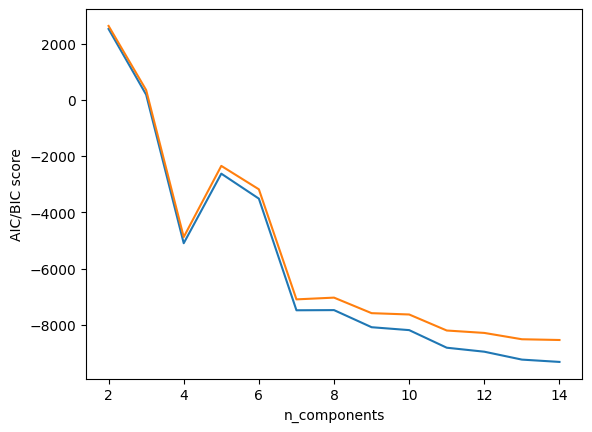

In [50]:
plt.plot(results.index, results['aic'])
plt.plot(results.index, results['bic'])
plt.xlabel('n_components')
plt.ylabel('AIC/BIC score')

In [51]:
gmm = GaussianMixture(n_components = 14).fit(X_scaled.loc[:, features])
scores = gmm.score(X_scaled.loc[:, features])
scores_oos_18 = gmm.score(pd.concat([X_oos_scaled.loc[:, features].iloc[0:15, :], X_test1_00.loc[:, features]  ]))
scores_oos_19 = gmm.score(pd.concat([X_oos_scaled.loc[:, features].iloc[15:30, :], X_test1_11.loc[:, features]  ]))
scores_oos_20 = gmm.score(pd.concat([X_oos_scaled.loc[:, features].iloc[30:, :], X_test1_22.loc[:, features]  ]))
# scores_oos_20 = gmm.score(X_test1.loc[:, features])
print(scores_oos_18)
print(scores_oos_19)
print(scores_oos_20)
# print(scores)

-885579.0281507826
7.771992903910802
7.800002939429895


In [52]:

features = [ 'C', 'N','LUMO (iminium)','SB1']
print(X_train1.loc[:, features].shape)





(307, 4)


                      aic          bic
n_components                          
2            -6060.948872 -5952.870287
3            -6840.416523 -6676.435222
4            -7576.614855 -7356.730838
5            -8583.629606 -8307.842872
6            -8916.484339  -8584.79489
7            -8960.634938 -8573.042772
8            -9033.848345 -8590.353463
9            -9016.979768  -8517.58217
10           -9130.221496 -8574.921181
11           -9124.500621 -8513.297591
12           -9159.545426 -8492.439679
13           -9306.864057 -8583.855594
14           -9515.779392 -8736.868213


Text(0, 0.5, 'AIC/BIC score')

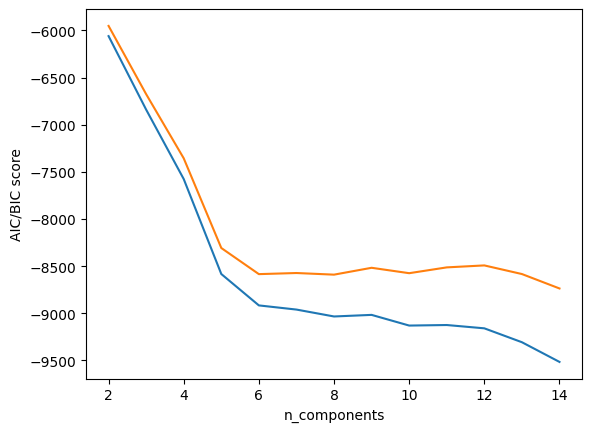

In [53]:
results = pd.DataFrame(columns = ['n_components', 'aic', 'bic'])
results.set_index('n_components', inplace = True)

for i in range(2, 15):
    gmm = GaussianMixture(n_components = i).fit(X_train1.loc[:, features])
    results.loc[i, 'aic'] = gmm.aic(X_train1.loc[:, features])
    results.loc[i, 'bic'] = gmm.bic(X_train1.loc[:, features])

print(results)

plt.plot(results.index, results['aic'])
plt.plot(results.index, results['bic'])
plt.xlabel('n_components')
plt.ylabel('AIC/BIC score')



In [54]:
gmm = GaussianMixture(n_components = 12).fit(X_train1.loc[:, features])
scores = gmm.score(X_train1.loc[:, features])
scores_oos_18 = gmm.score(pd.concat([X_oos_scaled.loc[:, features].iloc[0:15, :], X_test1_00.loc[:, features]  ]))
scores_oos_19 = gmm.score(pd.concat([X_oos_scaled.loc[:, features].iloc[15:30, :], X_test1_11.loc[:, features]  ]))
scores_oos_20 = gmm.score(pd.concat([X_oos_scaled.loc[:, features].iloc[30:, :], X_test1_22.loc[:, features]  ]))
print(scores_oos_18)
print(scores_oos_19)
print(scores_oos_20)
# print(scores)

14.15584492108596
-443.80568525676637
14.152812677325922


(1.0, 15.0)

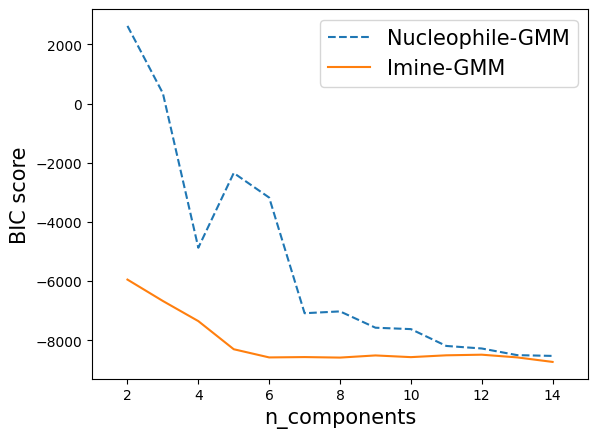

In [55]:
plt.plot(results_nuc.index, results_nuc['bic'],linestyle='dashed')
plt.plot(results.index, results['bic'])
plt.xlabel('n_components',fontsize=15)
plt.ylabel('BIC score',fontsize=15)
plt.legend(['Nucleophile-GMM', 'Imine-GMM' ],fontsize=15)
plt.xlim(1,15)

In [56]:
newtest1 = X_test1_22
new_column_names =list(newtest1.columns)
name_map = {old_name: new_name for old_name, new_name in zip(X_oos_scaled[30:].columns, new_column_names)}
X_oos_scaled[30:]=X_oos_scaled[30:].rename(columns=name_map)
newtest11=pd.concat([X_oos_scaled[30:],newtest1])

<ipython-input-56-e893b1866a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_oos_scaled[30:]=X_oos_scaled[30:].rename(columns=name_map)


In [57]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
forest = make_pipeline(StandardScaler(), SVR(C=9.99, epsilon=0.2))

forest.fit(X_train1, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(newtest11)



print('MSE: ' + str(mean_squared_error(pd.concat([Y_oos[30:],Y_test1_22]), Y_pred)))
print('MAE: ' + str(mean_absolute_error(pd.concat([Y_oos[30:],Y_test1_22]), Y_pred)))
print('r^2: ' + str(r2_score(pd.concat([Y_oos[30:],Y_test1_22]), Y_pred)))


MSE: 0.4779255408800326
MAE: 0.5547228299003875
r^2: 0.7455381018184069


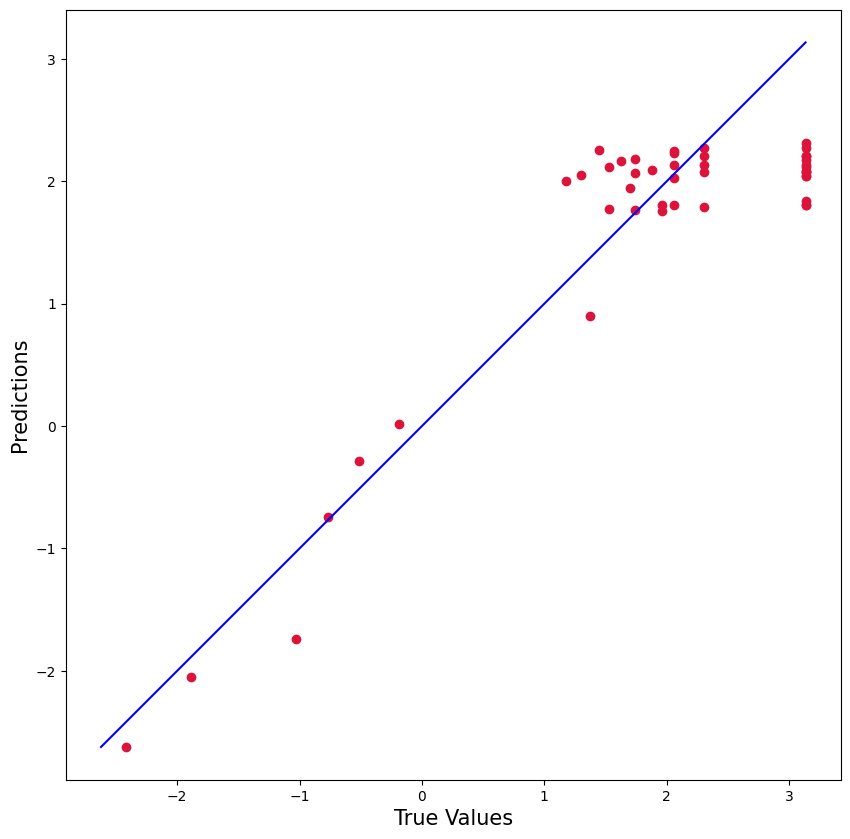

In [58]:
plt.figure(figsize=(10,10))
plt.scatter(pd.concat([Y_oos[30:],Y_test1_22]), Y_pred, c='crimson')
a111=np.asarray(pd.concat([Y_oos[30:],Y_test1_22]))
p1 = max(max(Y_pred), max(a111))
p2 = min(min(Y_pred), min(a111))
plt.plot([p1, [p2]], [p1, [p2]], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [59]:
from sklearn import linear_model
linear_model.LinearRegression()

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector


sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                k_features=50,
                                forward=True,
                                scoring='neg_mean_squared_error',
                                cv=None)
selected_features = sfs.fit(X_train1, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())

In [60]:
selected_features.k_feature_idx_

(4,
 14,
 15,
 22,
 30,
 32,
 38,
 50,
 53,
 63,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 152,
 158,
 166,
 229,
 236,
 242,
 251,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 271,
 273,
 275,
 276,
 277)

In [61]:
X_train1_new=X_train1.to_numpy()

In [62]:
X_train1_new11=X_train1_new[:,[ 4,
 14,
 15,
 22,
 30,
 32,
 38,
 50,
 53,
 63,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 152,
 158,
 166,
 229,
 236,
 242,
 251,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 271,
 273,
 275,
 276,
 277         ]]

In [63]:
newtest11_linear=newtest11.to_numpy()
newtest11_linear_muilti=newtest11_linear[:,[ 4,
 14,
 15,
 22,
 30,
 32,
 38,
 50,
 53,
 63,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 152,
 158,
 166,
 229,
 236,
 242,
 251,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 271,
 273,
 275,
 276,
 277         ]]

In [64]:
!pip install collinearity
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_regression
import numpy as np
import pandas as pd
import seaborn as sns
# from sklearn.datasets import load_boston

In [65]:
pipeline = make_pipeline(StandardScaler(),
    SelectNonCollinear(correlation_threshold=0.3,scoring=f_regression),
    LinearRegression()
)

forest.fit(X_train1_new11, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(newtest11_linear_muilti)



print('MSE: ' + str(mean_squared_error(pd.concat([Y_oos[30:],Y_test1_22]), Y_pred)))
print('MAE: ' + str(mean_absolute_error(pd.concat([Y_oos[30:],Y_test1_22]), Y_pred)))
print('r^2: ' + str(r2_score(pd.concat([Y_oos[30:],Y_test1_22]), Y_pred)))

MSE: 0.6725234102238798
MAE: 0.6423016942402757
r^2: 0.6419283572457501


In [66]:
print(p1)
print(p2)

[3.134303412644815]
-2.621850250381992


In [67]:
newtest1 = X_test1_11
new_column_names =list(newtest1.columns)
name_map = {old_name: new_name for old_name, new_name in zip(X_oos_scaled[15:30].columns, new_column_names)}
X_oos_scaled[15:30]=X_oos_scaled[15:30].rename(columns=name_map)
newtest11=pd.concat([X_oos_scaled[15:30],newtest1])

<ipython-input-67-848050cdd346>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_oos_scaled[15:30]=X_oos_scaled[15:30].rename(columns=name_map)


In [68]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
forest = make_pipeline(StandardScaler(), SVR(C=9.99, epsilon=0.2))


forest.fit(X_train1, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(newtest11)

print('MSE: ' + str(mean_squared_error(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))
print('MAE: ' + str(mean_absolute_error(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))
print('r^2: ' + str(r2_score(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))




MSE: 0.31177387452073435
MAE: 0.4691848238724443
r^2: 0.8925959520699375


In [70]:
newtest11.shape

(27, 278)

In [71]:
newtest11_linear=newtest11.to_numpy()
newtest11_linear_muilti=newtest11_linear[:,[ 4,
 14,
 15,
 22,
 30,
 32,
 38,
 50,
 53,
 63,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 152,
 158,
 166,
 229,
 236,
 242,
 251,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 271,
 273,
 275,
 276,
 277         ]]

In [72]:
pipeline = make_pipeline(StandardScaler(),
    SelectNonCollinear(correlation_threshold=0.3,scoring=f_regression),
    LinearRegression()
)

forest.fit(X_train1_new11, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(newtest11_linear_muilti)


print('MSE: ' + str(mean_squared_error(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))
print('MAE: ' + str(mean_absolute_error(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))
print('r^2: ' + str(r2_score(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))

MSE: 0.7270054687781285
MAE: 0.6479704813278148
r^2: 0.749551400565249


In [73]:
newtest1 = X_test1_00
new_column_names =list(newtest1.columns)
name_map = {old_name: new_name for old_name, new_name in zip(X_oos_scaled[0:15].columns, new_column_names)}
X_oos_scaled[0:15]=X_oos_scaled[0:15].rename(columns=name_map)
newtest11=pd.concat([X_oos_scaled[0:15],newtest1])

<ipython-input-73-5d4533a4d213>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_oos_scaled[0:15]=X_oos_scaled[0:15].rename(columns=name_map)


In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
forest = make_pipeline(StandardScaler(), SVR(C=9.99, epsilon=0.2))

forest.fit(X_train1, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(newtest11)



print('MSE: ' + str(mean_squared_error(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))
print('MAE: ' + str(mean_absolute_error(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))
print('r^2: ' + str(r2_score(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))


MSE: 0.8556961301003972
MAE: 0.7929246682349194
r^2: 0.44558912564664865


In [75]:
newtest11_linear=newtest11.to_numpy()
newtest11_linear_muilti=newtest11_linear[:,[ 4,
 14,
 15,
 22,
 30,
 32,
 38,
 50,
 53,
 63,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 152,
 158,
 166,
 229,
 236,
 242,
 251,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 271,
 273,
 275,
 276,
 277         ]]

In [76]:
pipeline = make_pipeline(StandardScaler(),
    SelectNonCollinear(correlation_threshold=0.3,scoring=f_regression),
    LinearRegression()
)

forest.fit(X_train1_new11, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(newtest11_linear_muilti)



print('MSE: ' + str(mean_squared_error(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))
print('MAE: ' + str(mean_absolute_error(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))
print('r^2: ' + str(r2_score(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))


MSE: 0.6403005763586866
MAE: 0.6732083787882585
r^2: 0.5851452520343595


In [77]:
newtest1 = X_test1_11.loc[:, catalyst_columns + nucleophile_columns + solvent_columns]
new_column_names =list(newtest1.columns)
name_map = {old_name: new_name for old_name, new_name in zip(X_oos_nuc_scaled[15:30], new_column_names)}
X_oos_nuc_scaled[15:30]=X_oos_nuc_scaled[15:30].rename(columns=name_map)
newtest11=pd.concat([X_oos_nuc_scaled[15:30],newtest1])

<ipython-input-77-dc7b74e48367>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_oos_nuc_scaled[15:30]=X_oos_nuc_scaled[15:30].rename(columns=name_map)


In [78]:
X_test1_11.shape

(12, 278)

In [79]:
forest = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=28,random_state=100))

forest.fit(X_train2, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(newtest11)



print('MSE: ' + str(mean_squared_error(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))
print('MAE: ' + str(mean_absolute_error(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))
print('r^2: ' + str(r2_score(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred)))



MSE: 0.07453161603902146
MAE: 0.20049034626850593
r^2: 0.9743243487810981


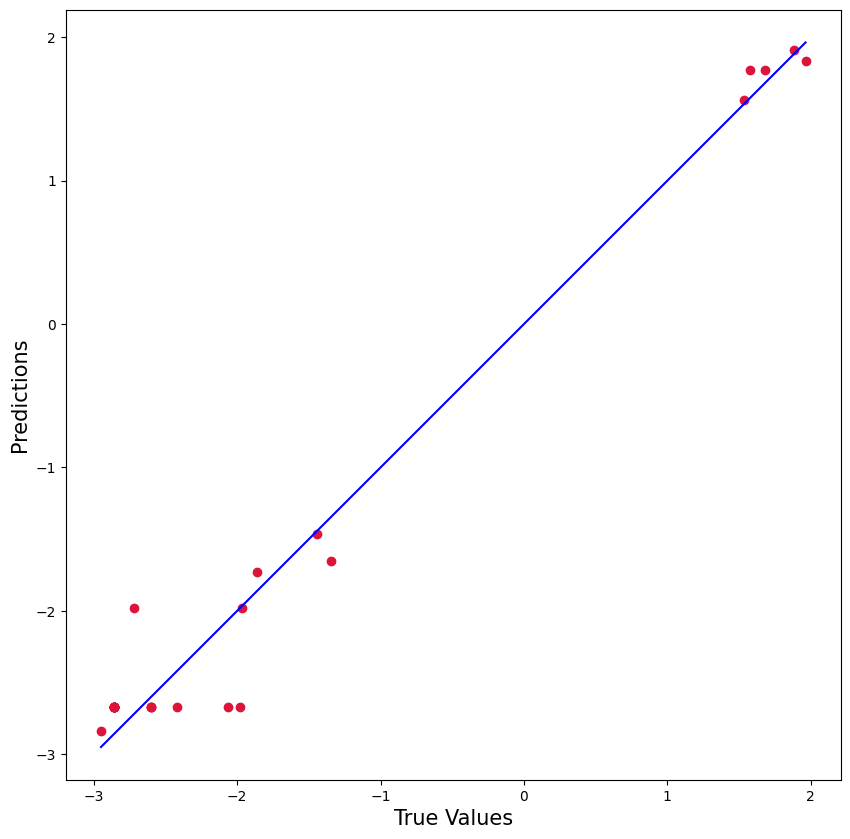

In [81]:
plt.figure(figsize=(10,10))
plt.scatter(pd.concat([Y_oos[15:30],Y_test1_11]), Y_pred, c='crimson')
a111=np.asarray(pd.concat([Y_oos[15:30],Y_test1_11]))
p1 = max(max(Y_pred), max(a111))
p2 = min(min(Y_pred), min(a111))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
print(p1)
print(p2)

In [82]:
newtest1 = X_test1_00
new_column_names =list(newtest1.columns)
name_map = {old_name: new_name for old_name, new_name in zip(X_oos_scaled[0:15].columns, new_column_names)}
X_oos_scaled[0:15]=X_oos_scaled[0:15].rename(columns=name_map)
newtest11=pd.concat([X_oos_scaled[0:15],newtest1])

<ipython-input-82-5d4533a4d213>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_oos_scaled[0:15]=X_oos_scaled[0:15].rename(columns=name_map)


In [83]:
forest = make_pipeline(StandardScaler(),Lasso(alpha=0.016,random_state=100))

forest.fit(X_train1, Y_train1.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(newtest11)


print('MSE: ' + str(mean_squared_error(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))
print('MAE: ' + str(mean_absolute_error(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))
print('r^2: ' + str(r2_score(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred)))


MSE: 0.24041167497684127
MAE: 0.42038963539628577
r^2: 0.8442357722092


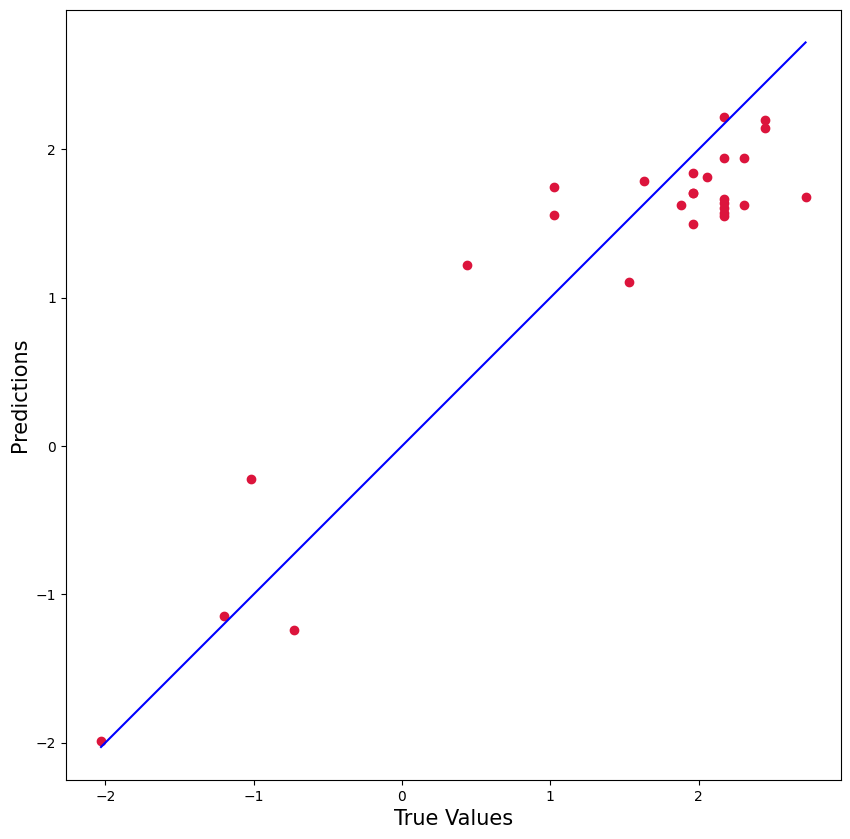

In [84]:
plt.figure(figsize=(10,10))
plt.scatter(pd.concat([Y_oos[0:15],Y_test1_00]), Y_pred, c='crimson')
a111=np.asarray(pd.concat([Y_oos[0:15],Y_test1_00]))
p1 = max(max(Y_pred), max(a111))
p2 = min(min(Y_pred), min(a111))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()